# Проект: интернет-магазин «В один клик»
# персонализированные предложения постоянным клиентам

**Описание проекта**  
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.  
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.      
Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность:  
1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.   
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.   

## Загрузка библиотек

In [131]:
!pip install -q --upgrade scikit-learn==1.5.1
import sklearn

import pandas as pd
import numpy as np
import re #регулярные выражения

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.set_theme(style="ticks")

# from scipy import stats as st
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

# импортируем модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные метрики
from sklearn.metrics import roc_auc_score

# загружаем нужные классы
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


!pip install shap -q
import shap

!pip install phik -q
import phik

In [132]:
start_high = '\u001b[1m \033[4m'
end_high = '\033[0m \033[0m'

## Загрузка данных и изучение данных

In [133]:
# Загрузка данных и предварительная информация о датафрейме
def upload_data (_name, sep=';', decimal='.'):
    df = pd.read_csv('/datasets/' + _name + '.csv', sep=sep, decimal=decimal)

    # переименование столбцов
    df.columns = [re.sub(r'(?:<1^)(?=[A-Z])','_',i).replace(' ','_').lower() for i in df.columns]

# сделаем индексами идентификаторы клиентов    
    print (start_high, _name, end_high)
    print(start_high, 'Размер:', end_high, df.shape)
    print('\n',start_high, 'Head', end_high)
    display(df.head())
    print('\n',start_high, 'Info', end_high)
    df.info()
    return df


In [134]:
df_market_file = upload_data('market_file', sep=',')

  market_file  
  Размер:   (1300, 13)

   Head  


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



   Info  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса     

In [135]:
df_market_money = upload_data('market_money', sep=',')

  market_money  
  Размер:   (3900, 3)

   Head  


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



   Info  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [136]:
df_market_time = upload_data('market_time', sep=',')

  market_time  
  Размер:   (2600, 3)

   Head  


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



   Info  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [137]:
df_money = upload_data('money', sep=';', decimal=',')

  money  
  Размер:   (1300, 2)

   Head  


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



   Info  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [138]:
dfs = [
    {'df': df_market_file, 'name': 'df_market_file'},
    {'df': df_market_money, 'name': 'df_market_money'},
    {'df': df_market_time, 'name': 'df_market_time'},
    {'df': df_money, 'name': 'df_money'}, ]

<div class="alert alert-info">

    
**Выводы:** 
* Исходные данные представляют собой 4 файла с разделителем **`,`** (запятая), кроме файла **`money.csv`** с разделителем **`;`** (точка с запятой) и с разделителем десятичных знаков **`,`** (запятая)   
* Файл с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении (**`market_file.csv`**) содержит 1300 записи в 13 полях.    
* Файл с данными  о выручке, которую получает магазин с покупателя (**`market_money.csv`**) содержит 3900 записей с 3мя полями.  
* Файл с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода (**`market_time.csv`**) содержит 2600 записей с 3мя полями.  
* Файл с данными о среднемесячной прибыли покупателя за последние 3 месяца (**`money.csv`**) содержит 1300 записей с 2мя полями.    

## Предобработка данных

### Переименование полей датафреймов (опционально)

Согласно условиям задачи можно оставить наименования столбцов на русском

### Устранение неявных дубликатов и изменение типов полей

#### Функция для изменение типов полей

In [139]:
# Загрузка данных и предварительная информация о датафрейме
def change_data_type (df):

    # категорийные поля
    cat_cols = df.select_dtypes(exclude='number').columns.tolist()
    if len(cat_cols) > 0: # есть поля типа "object"
        print(start_high, 'Категорийные поля:', end_high, cat_cols)
        for i in cat_cols:
            print('Поле:', i)
            display(df[i].value_counts()) # печать уникальных значений для выявления неявных дубликатов
            df[i] = df[i].astype('category')
        display(df[cat_cols].describe())
    
    # количественные поля
    
    qnt_cols = df.select_dtypes(include='number').columns.drop(['id']).tolist()
    if len(qnt_cols) > 0: # есть поля типа "object"
        print(start_high, 'Количественные поля:', end_high, qnt_cols)
        display(df[qnt_cols].describe())

    
    return cat_cols, qnt_cols

#### Изменение типов полей df_market_file

In [140]:
df_market_file.loc[df_market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'

df_market_file__cat_cols, df_market_file__qnt_cols = change_data_type(df_market_file)

  Категорийные поля:   ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
Поле: покупательская_активность


Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

Поле: тип_сервиса


стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

Поле: разрешить_сообщать


да     962
нет    338
Name: разрешить_сообщать, dtype: int64

Поле: популярная_категория


Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
count,1300,1300,1300,1300
unique,2,2,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,924,962,330


  Количественные поля:   ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']


,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


#### Изменение типов полей df_market_money

In [141]:
df_market_money__cat_cols, df_market_money__qnt_cols = change_data_type(df_market_money)

  Категорийные поля:   ['период']
Поле: период


текущий_месяц          1300
предыдущий_месяц       1300
препредыдущий_месяц    1300
Name: период, dtype: int64

,период
count,3900
unique,3
top,предыдущий_месяц
freq,1300


  Количественные поля:   ['выручка']


,выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


#### Изменение типов полей df_market_time

In [142]:
df_market_time.loc[df_market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'

df_market_time__cat_cols, df_market_time__qnt_cols = change_data_type(df_market_time)

  Категорийные поля:   ['период']
Поле: период


текущий_месяц       1300
предыдущий_месяц    1300
Name: период, dtype: int64

,период
count,2600
unique,2
top,предыдущий_месяц
freq,1300


  Количественные поля:   ['минут']


,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


#### Изменение типов полей df_money

In [143]:
df_money__cat_cols, df_money__qnt_cols = change_data_type(df_money)

  Количественные поля:   ['прибыль']


,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


### Проверка наличия пропущенных значений и дубликатов в датафреймах и их обработка.

In [144]:
def remove_duplicates (df, df_name, sort_col, prd = False):
    print(' --- = check duplicates in ' + start_high + df_name + end_high + ' before = ---')
    print('Дубликатов в', df_name, df.duplicated().sum())
    print(df_name, df.shape)    
    display(df[df.duplicated(keep=False)].sort_values(sort_col))
    if prd and (df.duplicated().sum() > 0):
        print(' --- = check duplicates in ' + start_high + df_name + end_high + ' after = ---')
        df = df.drop_duplicates()      
        display(df[df.duplicated(keep=False)].sort_values(sort_col))
        print(df_name, df.shape) 
    print(' --- = check duplicates in ' + start_high + df_name + end_high + ' end = ---')
    return df

In [145]:
# проверка наличия дубликатов
for df in dfs:
    print(df['name'], df['df'].duplicated().sum())

df_market_file 0
df_market_money 0
df_market_time 0
df_money 0


In [146]:
# проверка пропусков
for df in dfs:
    print(start_high + df['name'] + end_high)
    print(df['df'].isna().sum())

 df_market_file 
id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64
 df_market_money 
id         0
период     0
выручка    0
dtype: int64
 df_market_time 
id        0
период    0
минут     0
dtype: int64
 df_money 
id         0
прибыль    0
dtype: int64


### Выводы

<div class="alert alert-info">

* Исходные данные не имеют пропусков и дубликатов.
* Названия полей исходных данных на русском языке с пробелами. Первая буква большинства названий большая. Для стандартизации пробелы заменены символом подчеркивания. Первая буква всех полей - маленькая.    
* Решено сохранить названия полей на русском языке, т.к. требования к проекту описывают поля на русском языке.
* Устранены неявные дубликаты: 
    * **период** в **market_time**: 'предыдцщий_месяц' => 'предыдущий_месяц'
    * **тип_сервиса** в **market_file**: 'стандартт' => 'стандарт'
  
* Текстовые поля преобразованы к типу category.
* Для каждого датафрейма созданы списки с названиями категорийных и количественных полей.

## Исследовательский анализ данных

### Функция для вывода информации о датафрейме

In [147]:
# функция для вывода информации о датафрейме
def df_visualise (df, cat_cols=False, qnt_cols=False, rem_outliers = '-------', df_name=''):
    print(start_high + df_name + end_high)
    if len(cat_cols) > 0:
        print('\n' + start_high + 'Категорийные поля' + end_high)
        for i in cat_cols:
            plt.figure(figsize=(15,  df[i].unique().size))
            graph_data = sns.countplot(data=df, y=i, palette='pastel')
            plt.xlabel("Число покупателей")
            plt.show(graph_data)
            print(df[i].value_counts(normalize=True).round(2));
    if len(qnt_cols) > 0:
        print('\n' + start_high + 'Количественные поля' + end_high)
        k = -1
        for i in qnt_cols:
            k += 1
            ax = df[i].hist()
            ax.set_ylabel("Количество")            
            plt.figure(figsize=(15, 1))
            bp = plt.boxplot(df[i], vert=False)
            outliers = [flier.get_xdata() for flier in bp["fliers"]] # выбросы
            plt.yticks([1], ["{:>40}".format(i)])
            plt.show()
            if len(outliers[0]) > 0 and rem_outliers[k] == '+': # удаление выбросов
                for j in outliers[0]:
                    # print(j)
                    df = df[df[i] != j]
                print(i, " ящик с усами после удаления выбросов")
                plt.figure(figsize=(15, 1)) # печать ящика с усами после удаления выбросов
                plt.boxplot(df[i], vert=False)
                plt.yticks([1], ["{:>40}".format(i)])
                plt.ylabel(di[i]) 
                plt.show()
    return df

### Анализ df_market_file (поведение покупателя на сайте, коммуникации с покупателем и его продуктовом поведении)

 df_market_file (Поведение покупателя на сайте, коммуникации с покупателем и его продуктовом поведении) 

 Категорийные поля 


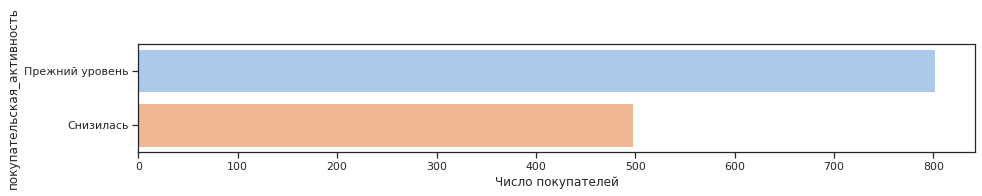

Прежний уровень    0.62
Снизилась          0.38
Name: покупательская_активность, dtype: float64


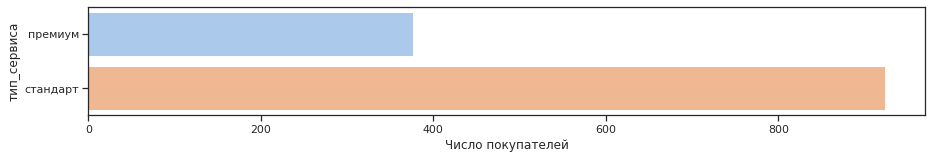

стандарт    0.71
премиум     0.29
Name: тип_сервиса, dtype: float64


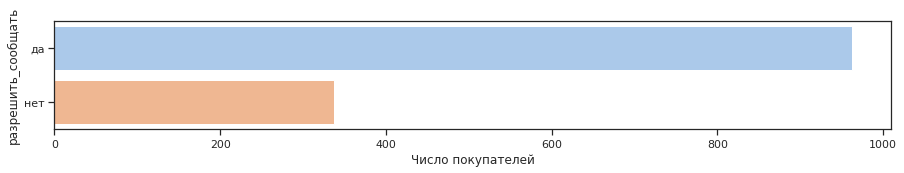

да     0.74
нет    0.26
Name: разрешить_сообщать, dtype: float64


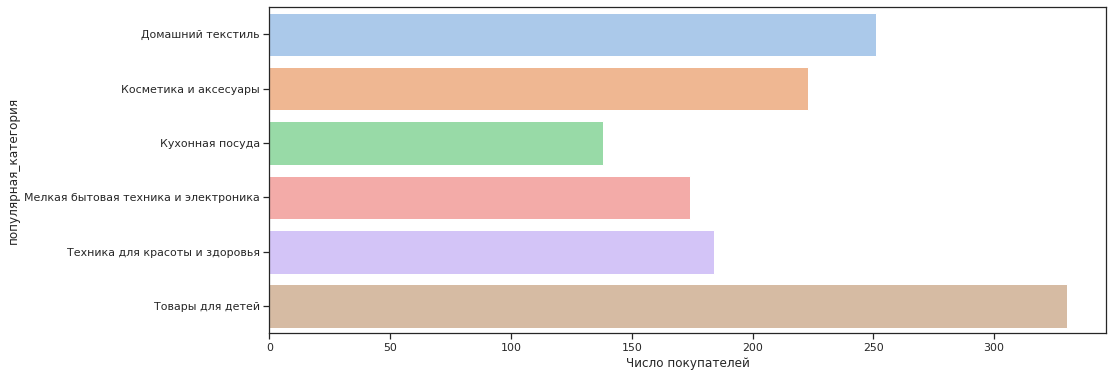

Товары для детей                        0.25
Домашний текстиль                       0.19
Косметика и аксесуары                   0.17
Техника для красоты и здоровья          0.14
Мелкая бытовая техника и электроника    0.13
Кухонная посуда                         0.11
Name: популярная_категория, dtype: float64

 Количественные поля 


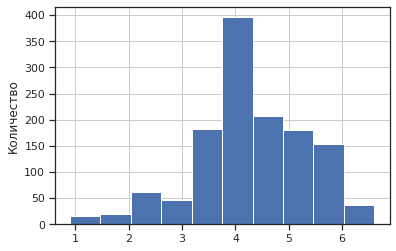

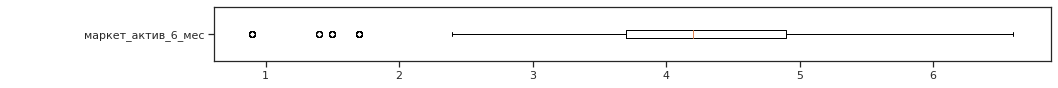

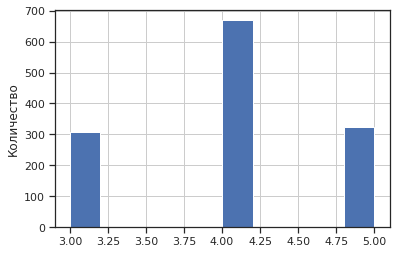

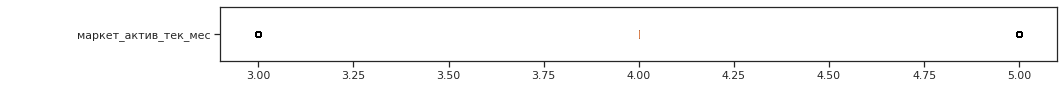

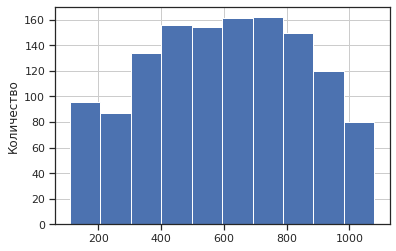

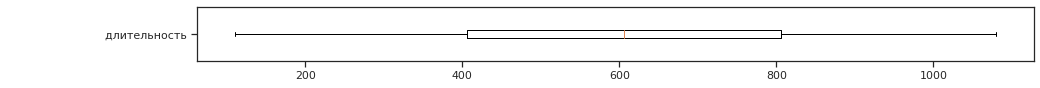

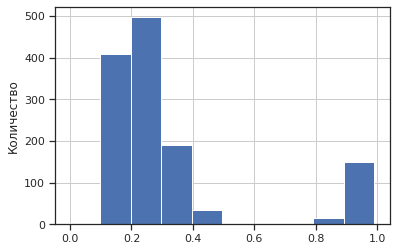

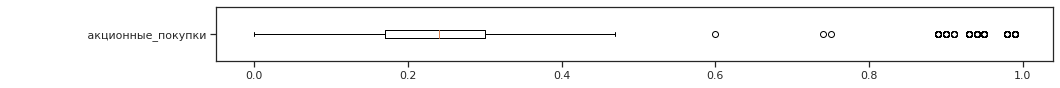

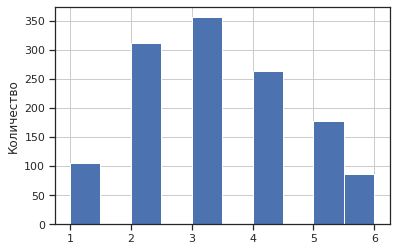

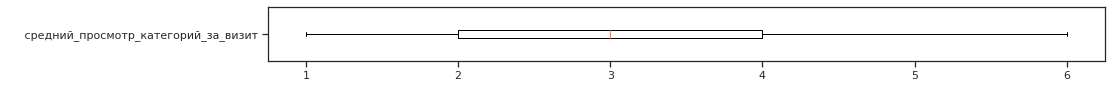

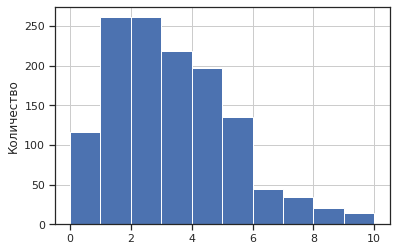

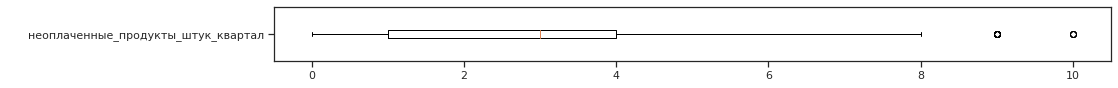

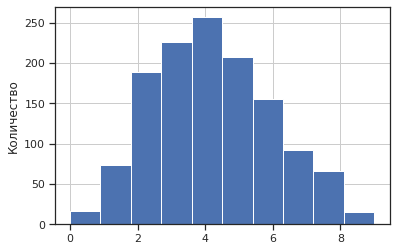

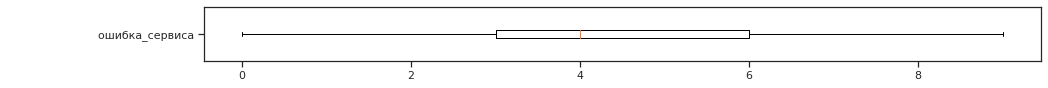

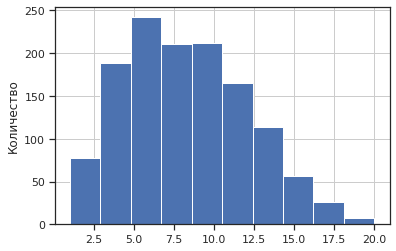

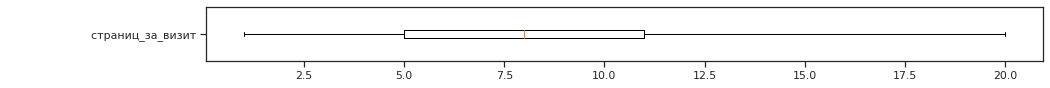

In [148]:
df_market_file = df_visualise (df_market_file, df_market_file__cat_cols, df_market_file__qnt_cols, '--------',
                              'df_market_file (Поведение покупателя на сайте, коммуникации с покупателем и его продуктовом поведении)')



### Анализ df_market_money  (выручка, которую получает магазин с покупателя)

 df_market_money (выручка, которую получает магазин с покупателя) 

 Категорийные поля 


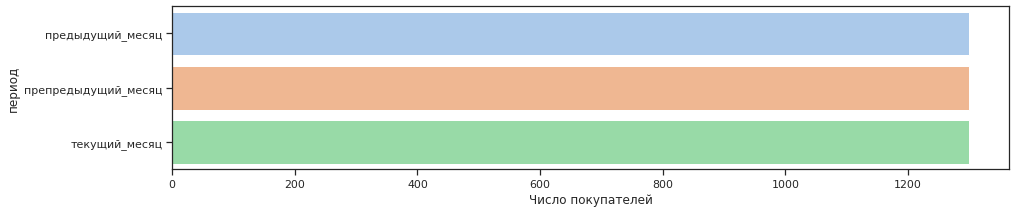

предыдущий_месяц       0.33
препредыдущий_месяц    0.33
текущий_месяц          0.33
Name: период, dtype: float64

 Количественные поля 


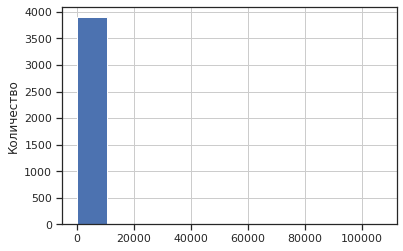

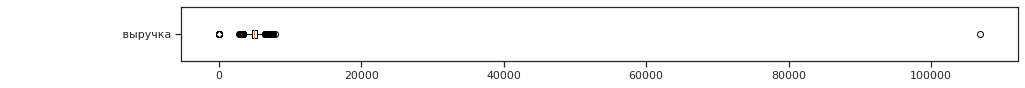

 df_market_money (выручка, которую получает магазин с покупателя) 

 Категорийные поля 


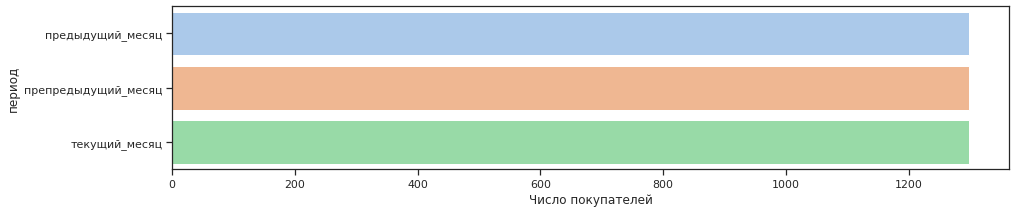

предыдущий_месяц       0.33
препредыдущий_месяц    0.33
текущий_месяц          0.33
Name: период, dtype: float64

 Количественные поля 


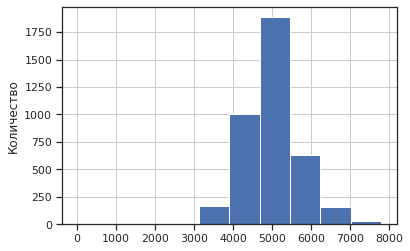

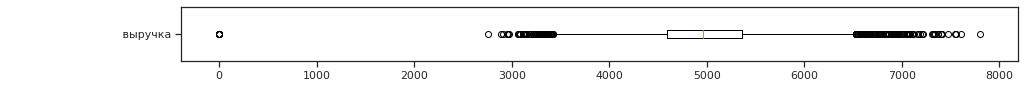

In [149]:
df_market_money = df_visualise (df_market_money, df_market_money__cat_cols, df_market_money__qnt_cols, '--------',
                              'df_market_money (выручка, которую получает магазин с покупателя)')

# Удаление всех строк для клиента с выбросом
# Выброс = 106862.2 id = 215380
if not(df_market_money[df_market_money['выручка'] > 100000].empty) :
    df_market_money = df_market_money[
        df_market_money['id'] != df_market_money[df_market_money['выручка'] > 100000
                                                ]['id'].values[0]]


    df_market_money = df_visualise (df_market_money, df_market_money__cat_cols, df_market_money__qnt_cols, '--------',
                              'df_market_money (выручка, которую получает магазин с покупателя)')

### Анализ df_market_time (время (в минутах), которое покупатель провёл на сайте в течение периода)

 df_market_time (время (в минутах), которое покупатель провёл на сайте в течение периода) 

 Категорийные поля 


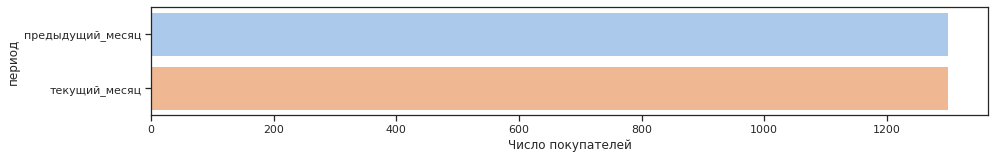

предыдущий_месяц    0.5
текущий_месяц       0.5
Name: период, dtype: float64

 Количественные поля 


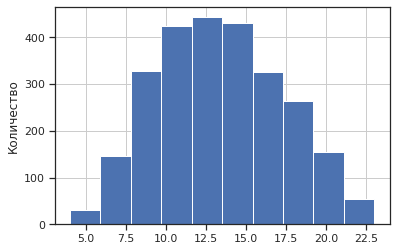

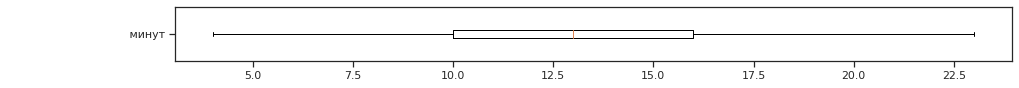

In [150]:
df_market_time = df_visualise (df_market_time, df_market_time__cat_cols, df_market_time__qnt_cols, '--------',
                              'df_market_time (время (в минутах), которое покупатель провёл на сайте в течение периода)')

### Анализ df_money (среднемесячная прибыль покупателя за последние 3 месяца)

 df_money (среднемесячная прибыль покупателя за последние 3 месяца) 

 Количественные поля 


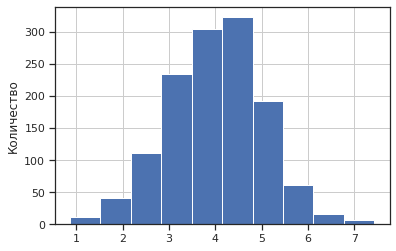

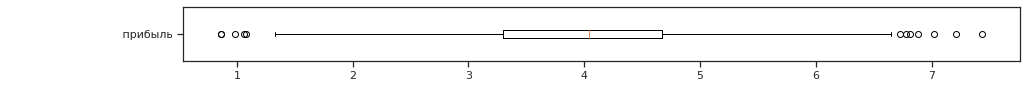

In [151]:
df_money = df_visualise (df_money, df_money__cat_cols, df_money__qnt_cols, '--------',
                              'df_money (среднемесячная прибыль покупателя за последние 3 месяца)')

###  Клиенты с покупательской активностью не менее трёх месяцев

Только одна таблица содержит информацию о покупках за три месяца. Это df_market_money.
Создадим датафрейм df_clients_3m со списком клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

In [152]:
# развернем df_market_money и удалим клиентов, у которых есть месяцы без покупок 
df_market_money_pivot = df_market_money.pivot_table(index='id', values='выручка', columns='период', aggfunc='sum'). \
    rename(columns={'препредыдущий_месяц':'выручка_препредыдущий_месяц',
                   'предыдущий_месяц':'выручка_предыдущий_месяц',
                   'текущий_месяц':'выручка_текущий_месяц'})

df_market_money_pivot = df_market_money_pivot[
                      (df_market_money_pivot['выручка_предыдущий_месяц'] != 0) & 
                      (df_market_money_pivot['выручка_препредыдущий_месяц'] != 0) &
                      (df_market_money_pivot['выручка_текущий_месяц'] != 0)]

display(df_market_money_pivot.shape)
df_market_money_pivot.head()

(1296, 3)

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


<div class="alert alert-info">


**Выводы**
    
Исходные данные представляют собой данные о 1300 клиентах интернет-магазина «В один клик».
Все клиенты из представленных файлов что-либо покупали за последние 3 месяца.
    
**Поведение покупателя на сайте, коммуникации с покупателем и его продуктовое поведение (market_file.csv):** 
* Категорийные поля:
    * покупательская активность: сохранилась на прежнем уровне у 62% покупателей и снизилась у 38% покупателей;
    * тип сервиса: стандарт у 71% и премиум у 29% покупателей.
    * разрешить сообщать: 74% - да, 26% - нет
    * популярные категории: 6 категорий распределены от 11% (Кухонная посуда) до 25% (Товары для детей).
* Количественные поля:    
    * среднемесячное значение маркетинговых коммуникаций компании распределено между 2,3 и 6,6 с небольшим количеством выбросов меньше 2.
    * количество маркетинговых коммуникаций в текущем месяце распределено между 3 и 5.
    * распределение длительности близко к нормальному. Интервал от 110 до 1079. Среднее 602 дня.
    * среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев имеет 2 пика: основной 24% и  небольшой около 90%.
    * среднее количество просмотренных категорий: распределение близко к нормальному в интервале от 1 до 6.
    * общее число неоплаченных товаров изменяется от 0 до 8 с выбросами на 9 и 10 товаров.
    * число сбоев, которые коснулись покупателя распределено нормально от 0 до 9. Большинство пользователей столкнулось с 4мя сбоями.
    * среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца распределено ассимитрично между 1 и 20. Большинство покупателей просмотрело 8 страниц.
    
**Выручка, которую получает магазин с покупателя (market_money.csv):**  
* данные предоставлены за 3 периода по 1300 записей в каждом периоде: текущий, предыдущий и предпредыдущий месяцы.  
* выручка распределена от 3000 до 7000 с многочисленными выбросами по краям. Максимальный выброс (106862 руб.) был удален для избежания искажений при построении моделей.
    
**Время (в минутах), которое покупатель провёл на сайте в течение периода (market_time.csv):**
* Данные предоставлены для каждого клиента за 2 периода: текущий месяц и предыдущий месяц
* Время на сайте изменяется от 4 до 23 минут. Большинство клиентов прводят 12,5 минут на сайте. Распределение близко к нормальному.
    
**Среднемесячная прибыль покупателя за последние 3 месяца (money.csv):**
* Большинство покупателей приносят от 1,3 до 6,7 прибыли с некоторым количеством выбросов по краям выборки. Среднее значение составляет 4.   

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

## Объединение таблиц

1. Объединим таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании не понадобятся.  
2. Данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода.

In [153]:
# Установим индексом поле 'id' 
if 'id' in df_market_file.columns:
    df_market_file = df_market_file.set_index('id')
    df_money = df_money.set_index('id')

In [154]:
# развернем df_market_time
df_market_time_pivot = df_market_time.pivot_table(index='id', values='минут', columns='период', aggfunc='sum'). \
    rename(columns={'предыдущий_месяц':'минут_предыдущий_месяц',
                   'текущий_месяц':'минут_текущий_месяц'})
df_market_time_pivot.shape

(1300, 2)

In [155]:
# объединим датафреймы
df_market_all = df_market_money_pivot.join([df_market_file,df_market_time_pivot]) 
df_market_all.shape

(1296, 17)

<div class="alert alert-info">


**Выводы**
* Объединенная таблица имеет 1300 записей.
* Для данных о выручке по периодам создано 3 столбца для текущего, предыдущего и предпредыдущего месяца.
* Для данных о времени, проведенном на сайте создано 2 столбца для текущего, предыдущего месяца. 

In [156]:
df_market_all.head()

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,5216.0,4472.0,4971.6,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
215350,5457.5,4826.0,5058.4,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
215351,6158.0,4793.0,6610.4,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
215352,5807.5,4594.0,5872.5,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
215353,4738.5,5124.0,5388.5,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10


## Корреляционный анализ

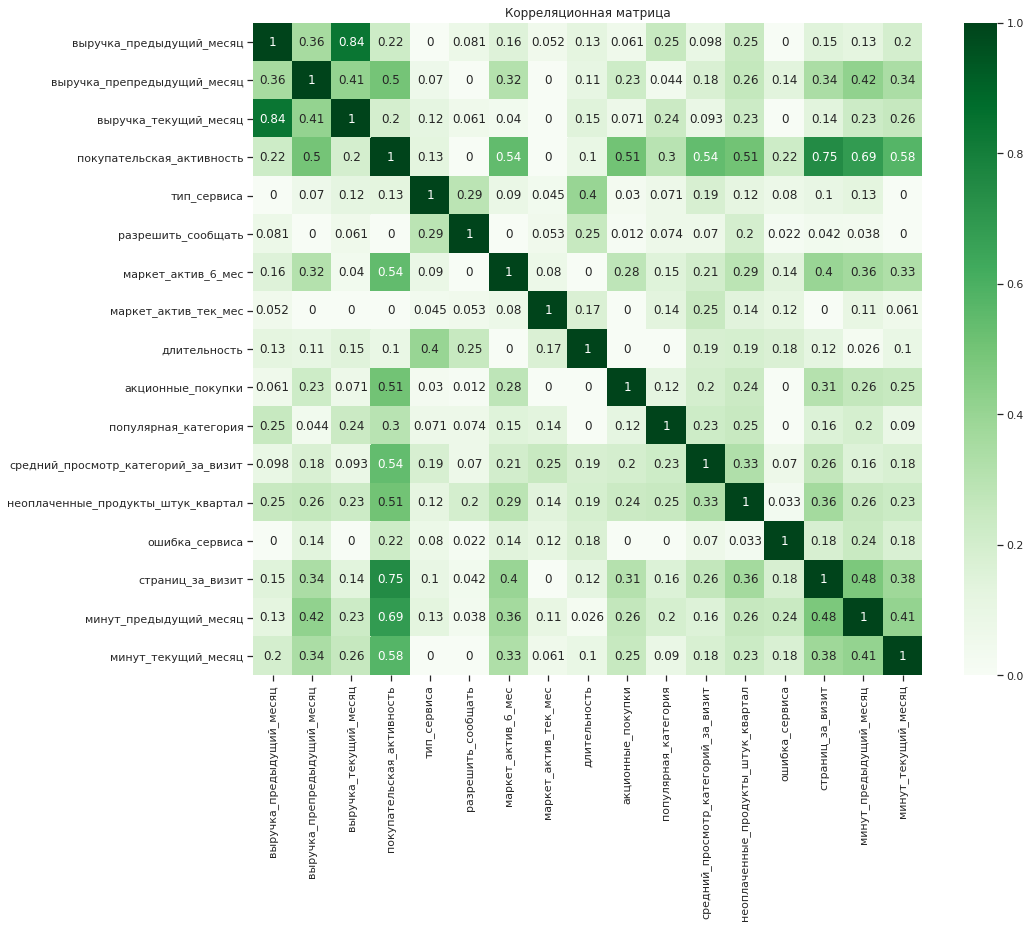

In [157]:
interval_cols = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит',
                'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса','страниц_за_визит',
                'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц','выручка_текущий_месяц',
                'минут_предыдущий_месяц','минут_текущий_месяц']

corr_matrix = df_market_all.phik_matrix(interval_cols= interval_cols)


plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Greens')
plt.title('Корреляционная матрица')
plt.show()

<div class="alert alert-info">


**Выводы**
* Объединенная таблица имеет 1300 записей.
* Для данных о выручке по периодам создано 3 столбца для текущего, предыдущего и предпредыдущего месяца.
* Для данных о времени, проведенном на сайте создано 2 столбца для текущего, предыдущего месяца. 

## Использование пайплайнов

In [158]:
df_market_all.head()

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,5216.0,4472.0,4971.6,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
215350,5457.5,4826.0,5058.4,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
215351,6158.0,4793.0,6610.4,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
215352,5807.5,4594.0,5872.5,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
215353,4738.5,5124.0,5388.5,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10


In [159]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = df_market_all.drop(['покупательская_активность'], axis=1)
y = df_market_all['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE #,
)

In [160]:
X_train.head(5)

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,
216580,5400.0,4818.0,6034.4,стандарт,да,4.3,4,514,0.11,Домашний текстиль,3,3,3,9,19,13
215897,5004.5,4460.0,5606.4,стандарт,да,3.9,4,627,0.24,Товары для детей,3,3,7,8,17,12
215618,5612.5,4441.0,6103.9,стандарт,нет,4.1,5,657,0.35,Товары для детей,2,6,2,4,10,7
215679,4541.0,5315.0,5341.8,стандарт,нет,5.5,3,712,0.95,Домашний текстиль,2,0,6,11,18,18
216150,5789.0,4979.0,6621.0,стандарт,да,4.3,4,283,0.11,Кухонная посуда,3,4,5,14,10,10


In [161]:
ord_cols = ['тип_сервиса', 'разрешить_сообщать']
cat_cols = ['популярная_категория']
#cat_cols = X_train.select_dtypes(exclude='number').columns.tolist()
num_cols = X_train.select_dtypes(include='number').columns.tolist()

In [162]:
# создадим экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучите модель и трансформируйте тренировочную выборку 
y_train_coded = label_encoder.fit_transform(y_train)

# трансформируем тестовую выборку
y_test_coded = label_encoder.transform(y_test)

# Проверка код-значение
print(label_encoder.inverse_transform([0, 1])) 

['Прежний уровень' 'Снизилась']


In [163]:
# ======================================== OE ============================================== # 
ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['да', 'нет'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        )
    ]
)
# ======================================== OHE ============================================= # 

ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# ======================================== preprocessor ===================================== # 

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_cols),
        ('oe_vs_ohe', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
) 

# ======================= итоговый пайплайн: подготовка данных и модель ====================== # 

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

In [164]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__oe_vs_ohe': [ord_pipe, ohe_pipe],  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
#    {
#        'models': [LogisticRegression(
#            random_state=RANDOM_STATE, 
#            solver='liblinear',
#            C = 1,
#            penalty='l1'
#        )],
#        'models__C': range(1, 10),
#        'models__penalty': ['l2'],
#        'preprocessor__oe_vs_ohe': [ohe_pipe],  
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
#    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': [1, 10],
        'models__kernel':['linear','poly', 'rbf'],  
        'preprocessor__oe_vs_ohe': [ord_pipe, ohe_pipe],  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  
    },]

In [165]:
scoring = {
    'roc_auc_score': 'roc_auc',
} 

In [166]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scoring,
    refit='roc_auc_score',
    random_state=RANDOM_STATE,
    n_jobs=-1
    )

randomized_search.fit(X_train, y_train_coded)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('\n',start_high,f'Метрика лучшей модели на тренировочной выборке: {randomized_search.best_score_:.2}', end_high)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('oe_vs_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                      

In [167]:
y_test_pred = randomized_search.predict_proba(X_test)
y_test_pred_1 = y_test_pred[:, 1]

print(start_high,f'Площадь ROC-кривой: {roc_auc_score(y_test_coded, y_test_pred_1):.2}', end_high)

  Площадь ROC-кривой: 0.9  


<div class="alert alert-info">


**Выводы**
* Подготовка данных:
    1. ***ColumnTransformer*** использован для подготовки данных. 
    2. Количественные и категориальные признаки обработаны раздельно. 
    3. Для кодирования категориальных признаков использованы ***OrdinalEncoder*** и ***OneHotEncoder***.
    4. Для масштабирования количественных признаков ***StandardScaler*** и ***MinMaxScaler***.

    
* Были обучены четыре модели: ***KNeighborsClassifier***, ***DecisionTreeClassifier***, ***LogisticRegression*** и  ***SVC*** с различным набором гиперпараметров.

    
* Для оценки качества модели была выбрана метрика ***ROC-AUC***, т.к. она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения. Это самая общая оценка итогов работы модели.     

    
* Для выбора лучшей модели использовался один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернул лучшую модель: ***LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')***


## Анализ важности признаков

1. Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP.  
2. Сделайте выводы о значимости признаков:  
    * какие признаки мало значимы для модели;  
    * какие признаки сильнее всего влияют на целевой признак;  
    * как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

In [168]:
#X_encoded = randomized_search.best_estimator_['preprocessor'].transform(X_train)

#encoder_col_names = randomized_search.best_estimator_['preprocessor'].get_feature_names_out()

#X_encoded_df = pd.DataFrame(X_encoded, columns=encoder_col_names)

#explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps.models, X_encoded_df) #, feature_perturbation="correlation_dependent")

#shap_values = explainer(X_encoded_df)

#shap.plots.beeswarm(shap_values, max_display=20) 


<div class="alert alert-info">


**Выводы**
* **Большие** значения следующих полей **повышают** вероятность снижения активности клиентов:
    1. акционные_покупки, 
    2. неоплаченные_продукты_штук_квартал,
    3. длительность
    4. выручка_предыдущий_месяц
    
    <br>
    
* **Большие** значения следующих полей **понижают** вероятность снижения активности клиентов:
    1. минут_предыдущий_месяц, 
    2. страниц_за_визит, 
    3. средний_просмотр_категорий_за_визит, 
    4. минут_текущий_месяц
    5. маркет_актив_6_мес
    6. выручка_препредыдущий_месяц   
    7. популярная_категория Мелкая бытовая техника и электроника
    8. маркет_актив_тек_месяц
    
    <br>
    
* Остальные поля влияют на снижение активности не значительно

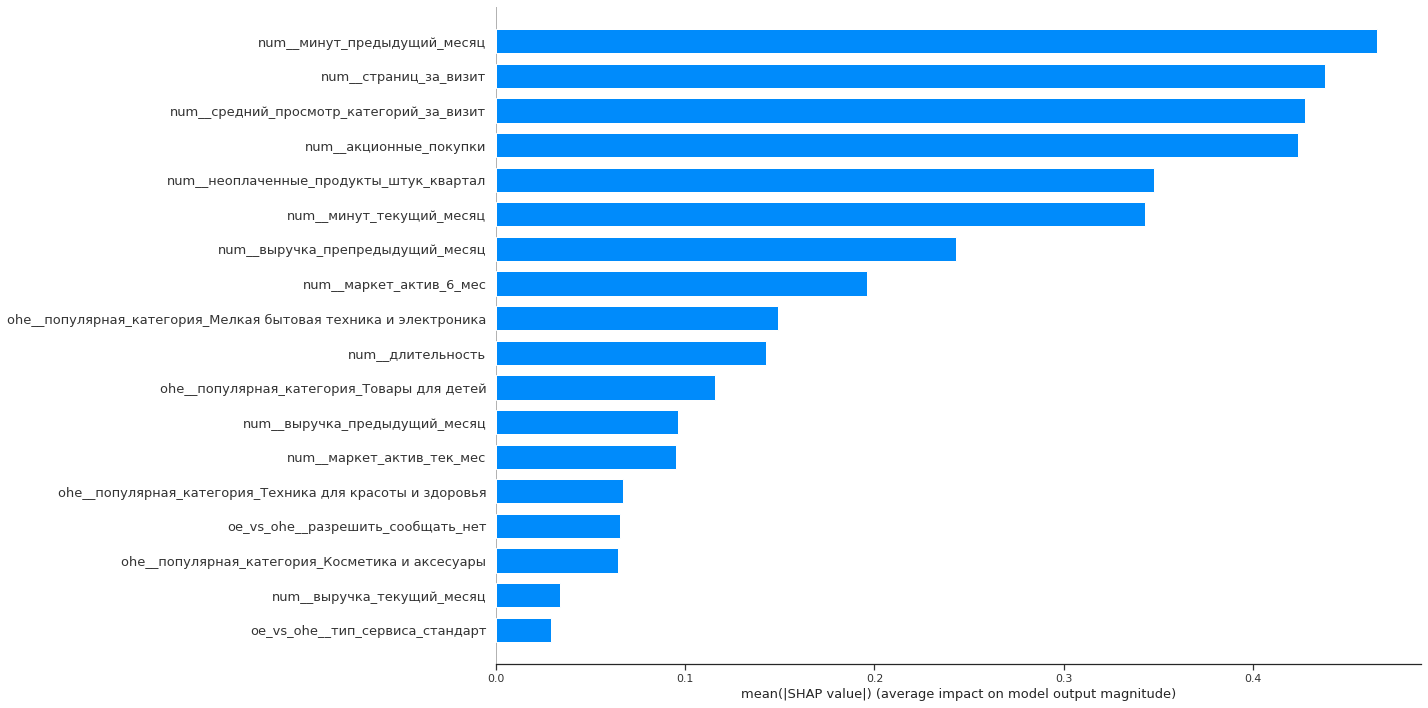

In [169]:
shap.summary_plot(
    shap_values, feature_names=encoder_col_names, plot_type="bar", max_display=18, plot_size=(20, 10))

## Сегментация покупателей

**Анализ сегмента покупателей "Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности".**

In [170]:
# Добавим информацию о прибыльности покупателей к результатам моделирования
df_market_all_profit = df_market_all.join([df_money])
# df_market_all_profit

# перестроим индекс
df_market_all_profit.reset_index(drop=True, inplace=True)

In [171]:
# Оценим вероятность снижения активности покупателей для всей выборки

# проанализируем все предоставленные данные
X_encoded = randomized_search.best_estimator_['preprocessor'].transform(X)

encoder_col_names = randomized_search.best_estimator_['preprocessor'].get_feature_names_out()

#X_encoded_df = pd.DataFrame(X_encoded, columns=encoder_col_names)
X_encoded_df = pd.DataFrame(X_encoded)

# трансформируем тестовую выборку
y_coded = label_encoder.transform(y)

df_proba = pd.DataFrame(randomized_search.best_estimator_.named_steps.models.predict_proba(X_encoded_df)[:,1], columns=['proba'])

In [172]:
df_market_all_proba = df_market_all_profit.join([df_proba]) 

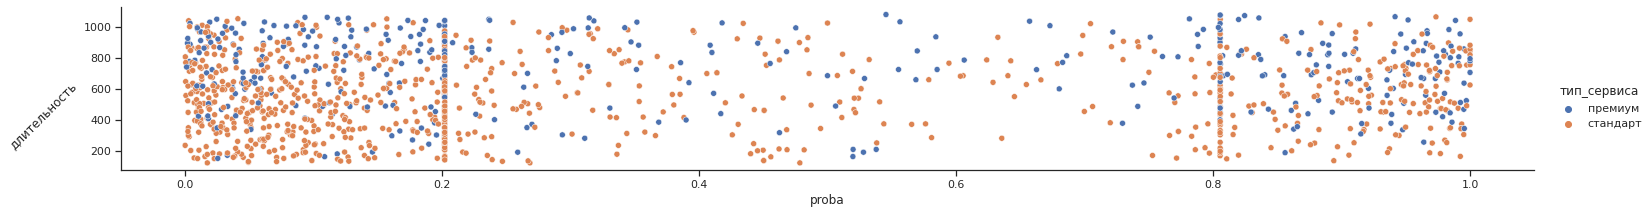

In [173]:
# Проверим, зависит ли вероятность снижения активности от длительности с момента регистрации и типа сервиса.
g=sns.pairplot(df_market_all_proba, 
               y_vars=['длительность'], 
               x_vars=['proba'], aspect=7, hue="тип_сервиса", height=3)
for ax in g.axes.flatten():
            # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 0)
    #        ax.set_xticklabels([category])
        # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 45)
        # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')
plt.show()

In [174]:
# функция для анализа прибыльности от категории и полей, которые влияют на покупательскую активность.
pd.options.mode.chained_assignment = None
def charts_categories (df):
#    import matplotlib.ticker as mticker
#    label_format = '{:,.0f}'
    
    print('Число записей:', df['proba'].count())

    pop_categories = df['популярная_категория'].unique()
    
    # df['prediction'] = 0
    # df['prediction'][df['proba'] > 0.5] = 1
    df.loc[df['proba'] < 0.5, 'prediction'] = 'Прежний уровень'
    df.loc[df['proba'] > 0.5, 'prediction'] = 'Снизилась'
    
    print('Уровень активности')
    print(df[["популярная_категория","prediction"]].value_counts().sort_index())
    
    for category in pop_categories:
        print (' Категория:', category)
        for prediction in ['Прежний уровень', 'Снизилась']:
#        for prediction in range(0,2):

            print (' Снижение активности:', prediction)
            df_analysis = df.loc[(df["популярная_категория"] == category)&
                                               (df["prediction"] == prediction)]
#            display(df_analysis)
            g=sns.pairplot(df_analysis, 
                           y_vars=["прибыль"], 
                           x_vars=['страниц_за_визит','минут_предыдущий_месяц','средний_просмотр_категорий_за_визит',
                                    'акционные_покупки','маркет_актив_тек_мес','минут_текущий_месяц',
                                    'маркет_актив_6_мес','выручка_текущий_месяц'], aspect=1, hue="популярная_категория")
            for ax in g.axes.flatten():
            # rotate x axis labels
                ax.set_xlabel(ax.get_xlabel(), rotation = 10)
    #        ax.set_xticklabels([category])
        # rotate y axis labels
                ax.set_ylabel(ax.get_ylabel(), rotation = 45)
        # set y labels alignment
                ax.yaxis.get_label().set_horizontalalignment('right')
            plt.show()

Число записей: 137
Уровень активности
популярная_категория                  prediction     
Домашний текстиль                     Прежний уровень     3
                                      Снизилась          17
Косметика и аксесуары                 Прежний уровень     2
                                      Снизилась          25
Кухонная посуда                       Прежний уровень     2
                                      Снизилась          20
Мелкая бытовая техника и электроника  Прежний уровень     5
                                      Снизилась           8
Техника для красоты и здоровья        Прежний уровень    13
                                      Снизилась           8
Товары для детей                      Прежний уровень     4
                                      Снизилась          30
dtype: int64
 Категория: Товары для детей
 Снижение активности: Прежний уровень


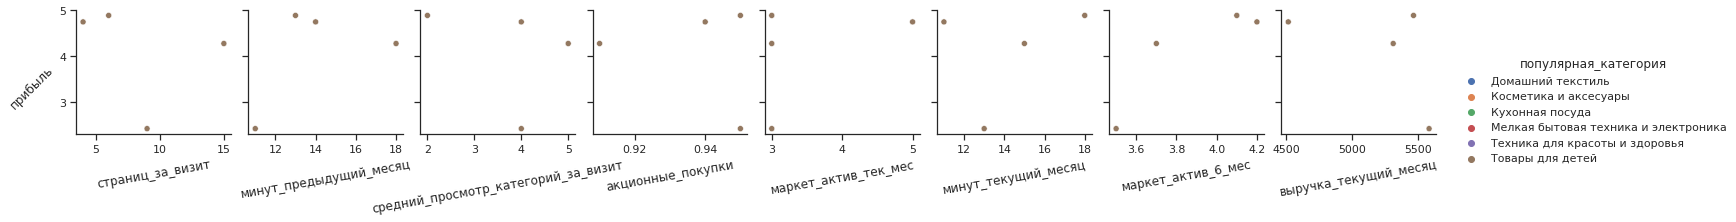

 Снижение активности: Снизилась


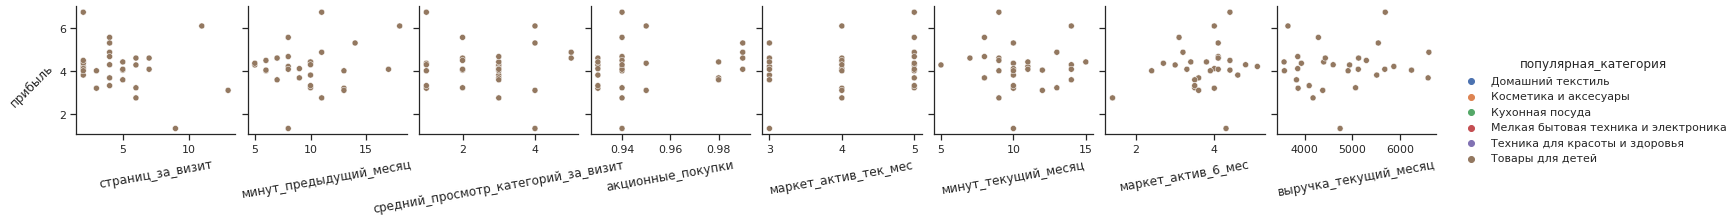

 Категория: Домашний текстиль
 Снижение активности: Прежний уровень


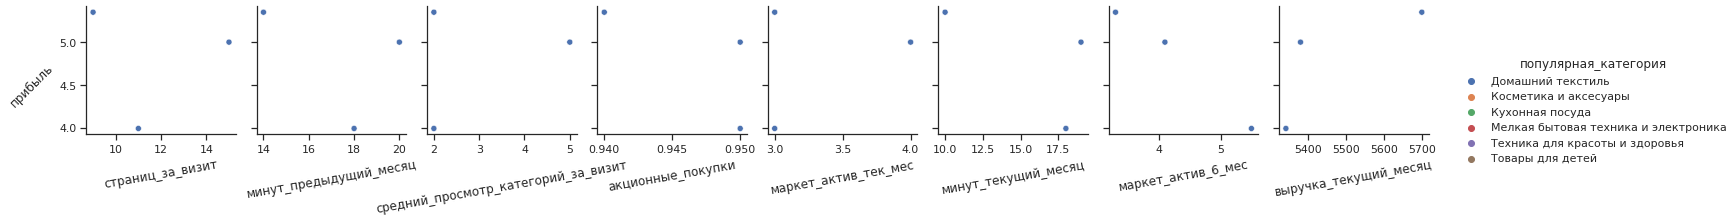

 Снижение активности: Снизилась


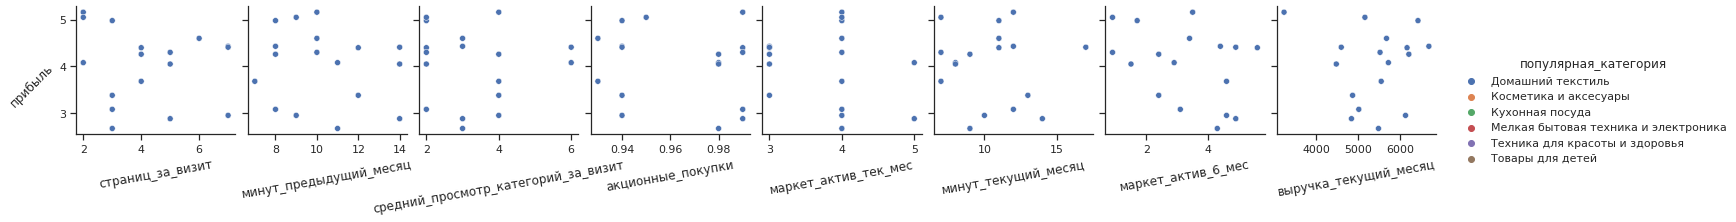

 Категория: Техника для красоты и здоровья
 Снижение активности: Прежний уровень


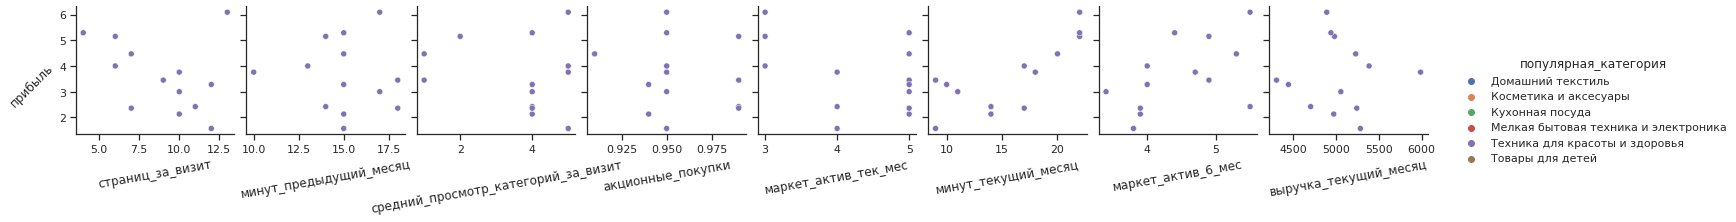

 Снижение активности: Снизилась


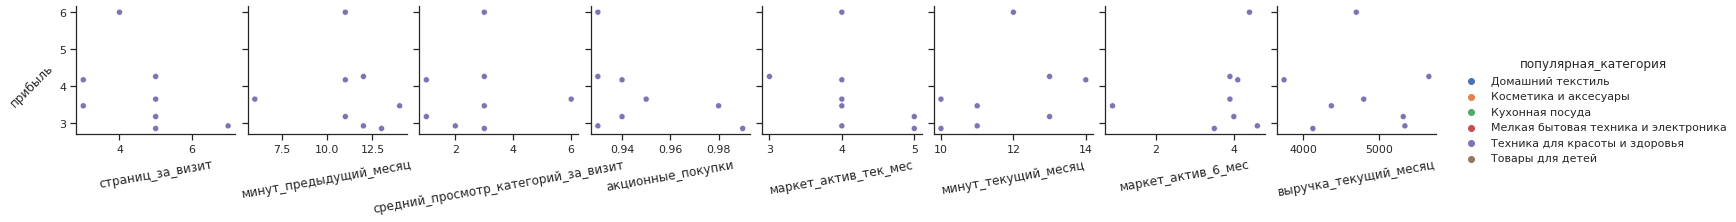

 Категория: Кухонная посуда
 Снижение активности: Прежний уровень


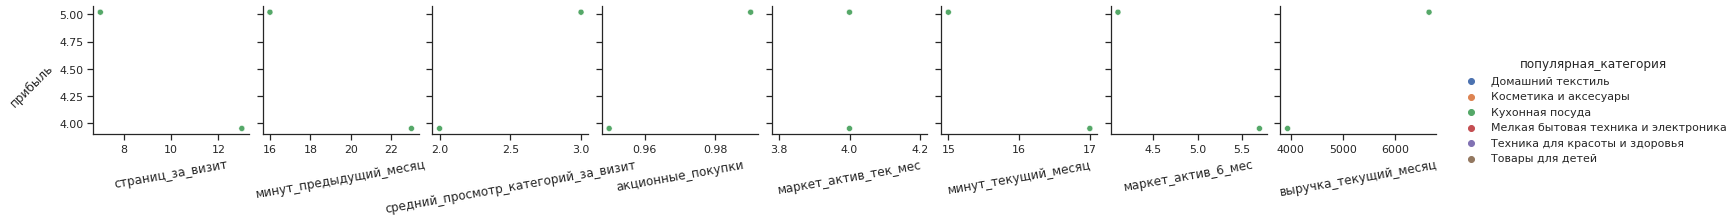

 Снижение активности: Снизилась


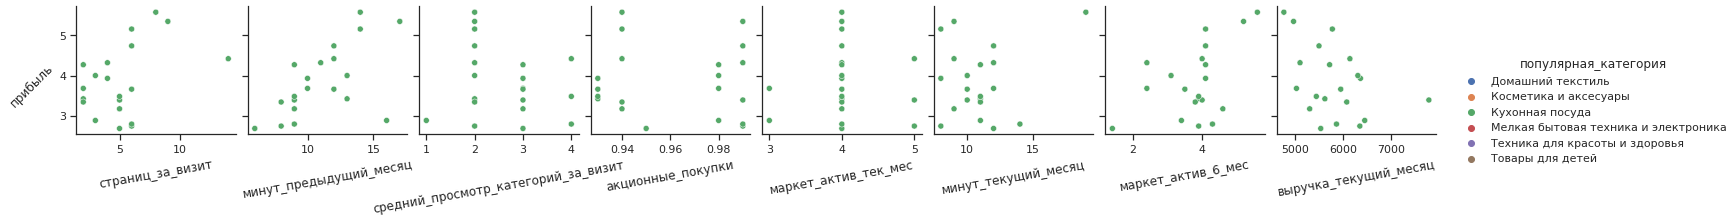

 Категория: Косметика и аксесуары
 Снижение активности: Прежний уровень


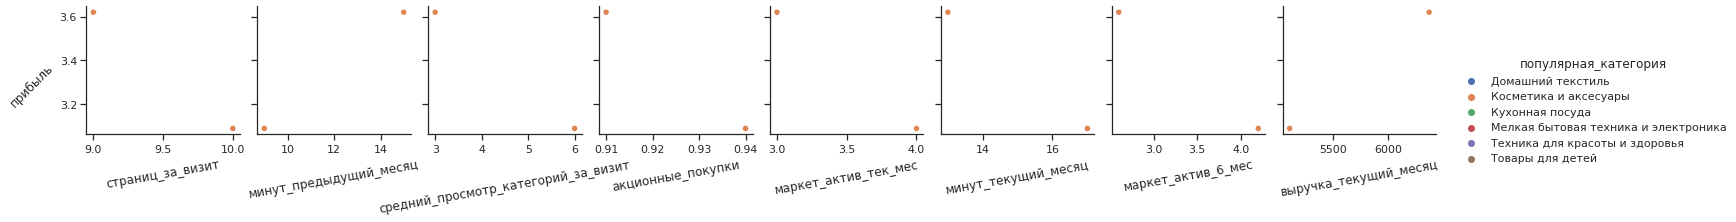

 Снижение активности: Снизилась


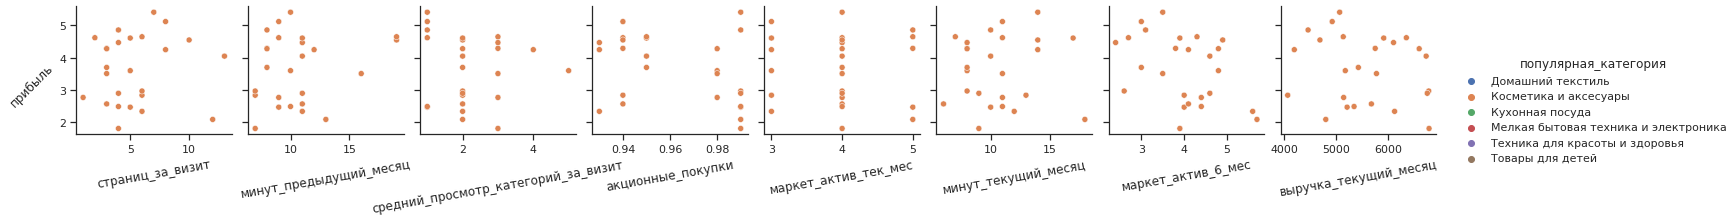

 Категория: Мелкая бытовая техника и электроника
 Снижение активности: Прежний уровень


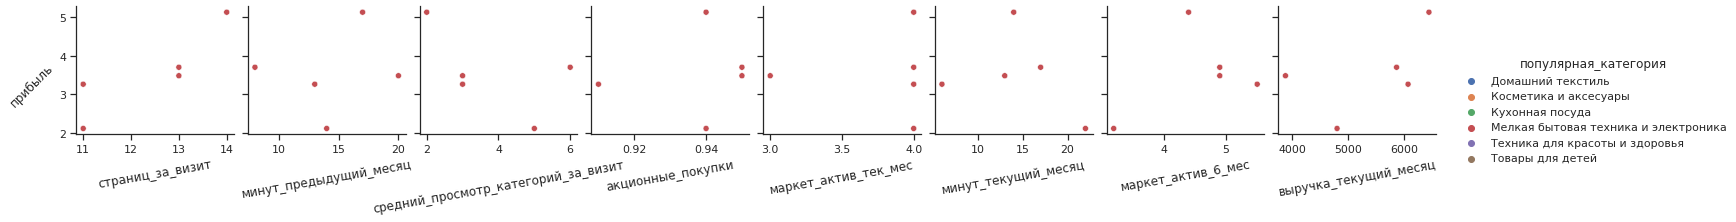

 Снижение активности: Снизилась


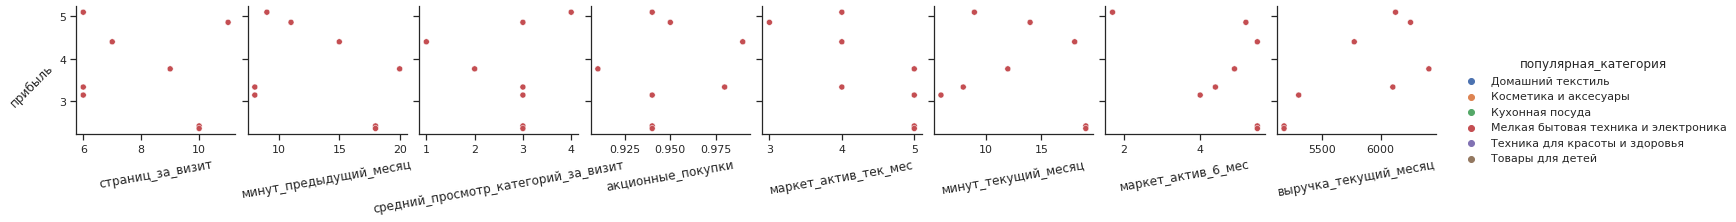

In [175]:
# Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
charts_categories (df_market_all_proba.loc[df_market_all_proba['акционные_покупки']> 0.90]) 

 Категория: Товары для детей


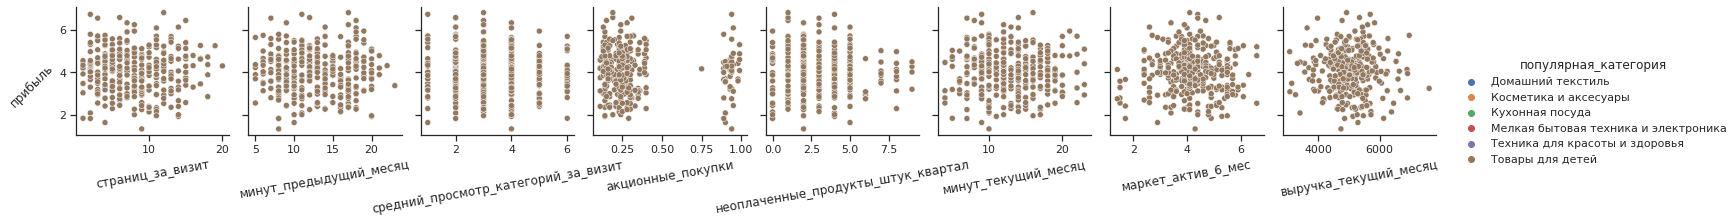

 Категория: Домашний текстиль


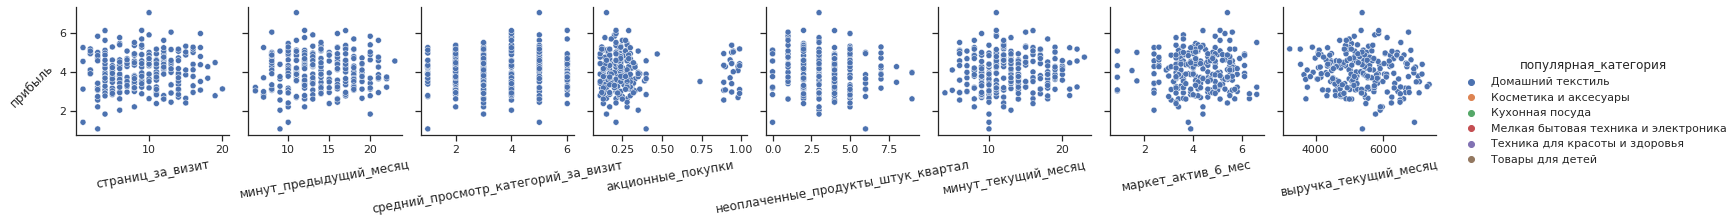

 Категория: Косметика и аксесуары


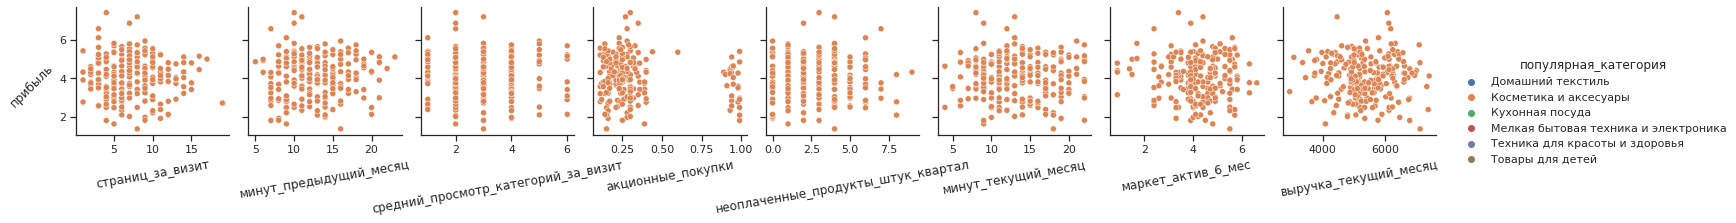

 Категория: Кухонная посуда


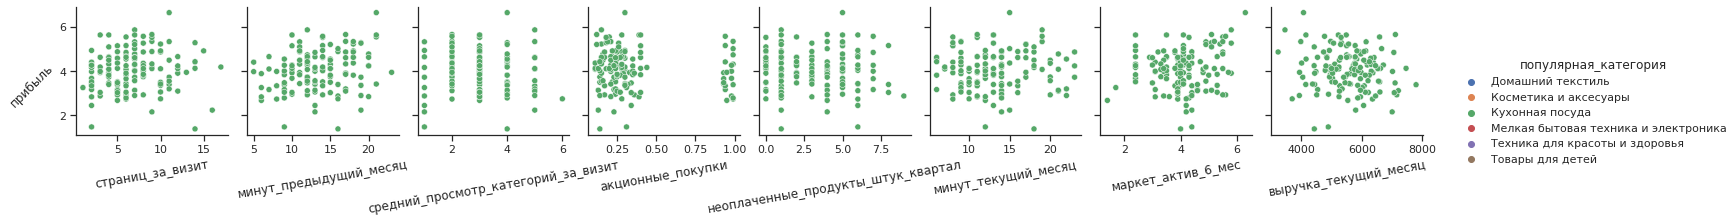

 Категория: Техника для красоты и здоровья


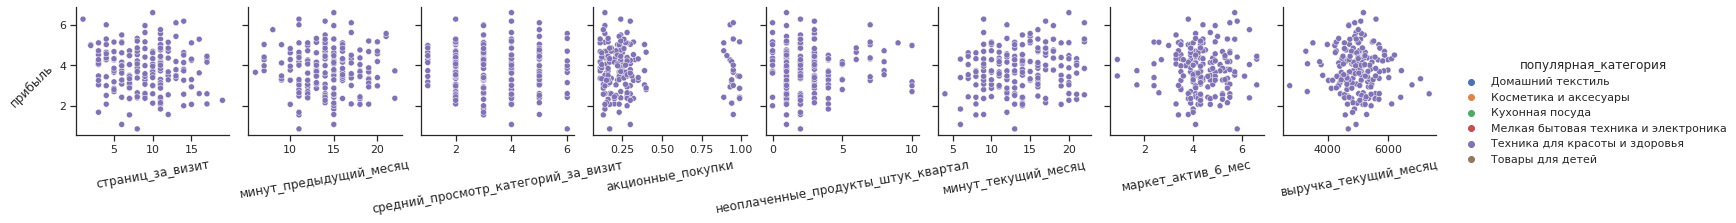

 Категория: Мелкая бытовая техника и электроника


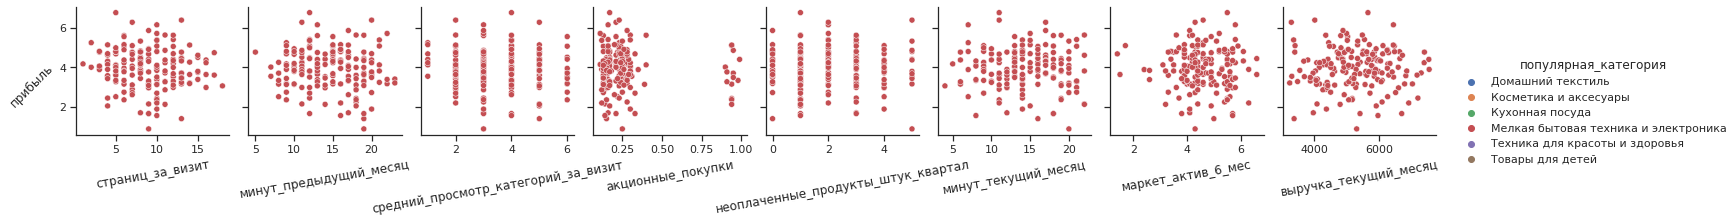

In [176]:


pop_categories = df_market_all['популярная_категория'].unique()
for category in pop_categories:
    print (' Категория:', category)
    g=sns.pairplot(df_market_all_profit[df_market_all_profit["популярная_категория"] == category], 
                   y_vars=["прибыль"], 
                   x_vars=['страниц_за_визит','минут_предыдущий_месяц','средний_просмотр_категорий_за_визит',
                           'акционные_покупки','неоплаченные_продукты_штук_квартал','минут_текущий_месяц',
                          'маркет_актив_6_мес','выручка_текущий_месяц'], aspect=1, hue="популярная_категория")
    for ax in g.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation = 10)
#        ax.set_xticklabels([category])
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation = 45)
        # set y labels alignment
        ax.yaxis.get_label().set_horizontalalignment('right')
    plt.show()


<div class="alert alert-info">

**Выводы анализа сегмента покупателей "Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности".**  
Покупательская активность снижается для покупателей с высокой долей акционных покупок (90%), кроме покупателей, у которых популярная категория "Мелкая бытовая техника и электроника" и "Техника для красоты и здоровья".
Это с высокой долей вероятности означает, что в текущем месяце были акции в этих категориях.

## Общий вывод

<div class="alert alert-info">


**Предпосылки проекта**  
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. В прошлом периоде активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.  
    
<br>
    
**Задача**    
Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.  
    
<br>
    
**Исходные данные**   
* Исходные данные представляют собой 4 файла с разделителем , (запятая), кроме файла **money.csv** с разделителем ; (точка с запятой) и с разделителем десятичных знаков , (запятая).
* Файл с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении (**market_file.csv**) содержит 1300 записи об уникальных клиентах в 13 полях.  
* Файл с данными о выручке, которую получает магазин с покупателя (**market_money.csv**) содержит 3900 записей за 3 месяца с 3мя полями.  
* Файл с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода (**market_time.csv**) содержит 2600 записей за 2 месяца с 3мя полями.  
* Файл с данными о среднемесячной прибыли покупателя за последние 3 месяца (**money.csv**) содержит 1300 записей с 2мя полями. * Исходные данные не имеют пропусков и дубликатов.
* Названия полей исходных данных на русском языке с пробелами. Первая буква большинства названий большая. Для стандартизации пробелы заменены символом подчеркивания. Первая буква всех полей - маленькая.    
* Решено сохранить названия полей на русском языке, т.к. требования к проекту описывают поля на русском языке.
* Устранены неявные дубликаты.  
* Текстовые поля преобразованы к типу category. 
    
<br>
    
**Поиск лучшей модели**
Для поиска лучшей модели были использованы пайплайны.
* Для подготовки данных использован ***ColumnTransformer***.
* Для кодирования целевого признака были использованы ***LabelEncoder*** были использованы.    
* Для кодирования категориальных признаков был использованы ***OneHotEncoder*** и ***OrdinalEncoder***. 
* Для масштабирования количественных были использованы скейлеры: ***StandardScaler***, ***MinMaxScaler***.
* Были обучены четыре модели: ***DecisionTreeClassifier***, ***KNeighborsClassifier***, ***LogisticRegression*** и  ***SVC***.
* Лучшей моделью оказалась ***LogisticRegression*** с гиперпараметрами C=1, penalty='l1', solver='liblinear'.
    
 
    
**Выводы и предложения для сегмента покупателей 'Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности':**   

Покупательская активность снижается для покупателей с высокой долей акционных покупок (90%), кроме покупателей, у которых популярная категория "Мелкая бытовая техника и электроника" и "Техника для красоты и здоровья".
Это с высокой долей вероятности означает, что в текущем месяце были акции в этих категориях.    
    
* **Большие** значения следующих полей **повышают** вероятность снижения активности клиентов:
    1. **акционные покупки**: возможно, клиенты "ловят" акции на определенные товары и после этого не планируют пользоваться магазином до акций в предпочитаемых категориях.
    2. **неоплаченные продукты штук квартал**: возможные причины:  
        * покупатель ждет скидок или более подходящего времени для покупки;
        * дорогая или не удобная доставка;
        * не удобные способы оплаты;
        * Корзина используется, как "список желаний";
        * Клиент забыл о заказе.
    3. **выручка предыдущий месяц**: активность покупателей носит периодический характер, после покупок на большую сумму, следует период снижения.   
    
**Предложнения**   <br>  
    
* Персонализированные предложения: Использование данные о предыдущих поисках товаров и брошенных товарах в корзине для отправки персонализированных предложений и скидок увеличивает вероятность завершения покупки.   
* Ретаргетинг: Настройка рекламы таким образом, чтобы ее видели только те клиенты, которые не завершили заказ.    
* Упростить путь клиента      
* Добавить несколько способов оплаты    
* Расширьте функционал личного кабинета   
* Используйте акции и скидки   
    
